In [1]:
# python
import sys
import os
import importlib
# columnar analysis
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
fname = '~/local_data/tta_mAlp-0p35GeV_ctau-1e3mm_part-0.root'
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema,
    metadata = {
       "dataset": "tt_alp", 
    },
).events()

In [3]:
utilities.print_list(ak.fields(events))

PatDSAMuonVertex
Muon
LHEScaleWeight
HLTriggerFirstPath
luminosityBlock
run
fixedGridRhoFastjetCentral
Pileup
OtherPV
FatJet
IsoTrack
RawMET
SoftActivityJet
SoftActivityJetNjets5
btagWeight
Electron
CorrT1METJet
GenPart
TrigObj
RawPuppiMET
HLT
SoftActivityJetHT2
LHEPart
HLTriggerFinalPath
SubJet
LHEReweightingWeight
LHEPdfWeight
SoftActivityJetNjets10
Tau
GenVisTau
L1simulation
fixedGridRhoFastjetCentralNeutral
DSAMuonVertex
GenIsolatedPhoton
PV
DSAMuon
Flag
CaloMET
MET
DeepMETResponseTune
GenMET
GenVtx
SoftActivityJetNjets2
Photon
fixedGridRhoFastjetAll
event
PatMuonVertex
FsrPhoton
SubGenJetAK8
Generator
LowPtElectron
fixedGridRhoFastjetCentralCalo
PuppiMET
LHE
SoftActivityJetHT
boostedTau
SoftActivityJetHT5
L1
PSWeight
Jet
L1PreFiringWeight
SV
GenDressedLepton
DeepMETResolutionTune
genTtbarId
TkMET
SoftActivityJetHT10
L1Reco
GenJetAK8
BS
HTXS
genWeight
ChsMET
fixedGridRhoFastjetCentralChargedPileUp
GenJet
LHEWeight


In [4]:
ak.num(events.Muon)

<Array [0, 1, 2, 0, 0, 0, ... 1, 3, 1, 1, 1, 1] type='100 * int64'>

In [5]:
events.PV.npvs

<Array [18, 19, 34, 26, 37, ... 27, 27, 12, 38] type='100 * int32[parameters={"_...'>

In [6]:
p = sidm_processor.SidmProcessor(
    ["llpnano"],
    ["muon_base", "dsaMuon_base"],
    llpnanoaod=True,
)
out = p.process(events)

Not applying any cuts to the lepton jets for channel  llpnano


In [7]:
out["tt_alp"]["hists"].keys()

dict_keys(['muon_n', 'muon_pt', 'muon_eta_phi', 'muon_absD0', 'muon_absD0_lowRange', 'dsaMuon_n', 'dsaMuon_pt', 'dsaMuon_eta_phi', 'dsaMuon_absD0', 'dsaMuon_absD0_lowRange'])

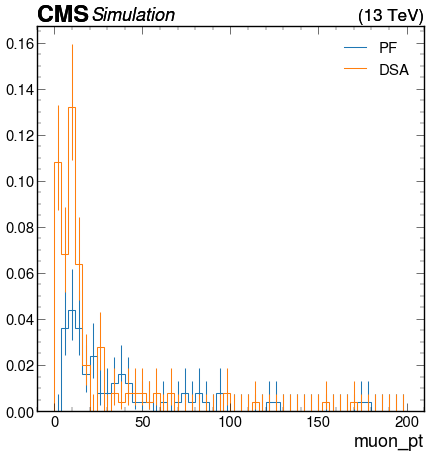

In [8]:
utilities.plot(out["tt_alp"]["hists"]["muon_pt"]["llpnano", ::2j])
utilities.plot(out["tt_alp"]["hists"]["dsaMuon_pt"]["llpnano", ::2j])
plt.legend(["PF", "DSA"])

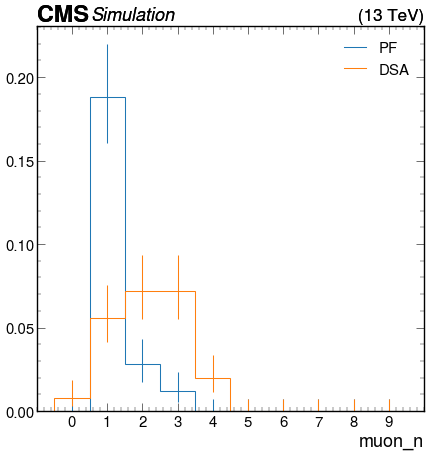

In [9]:
utilities.plot(out["tt_alp"]["hists"]["muon_n"]["llpnano", :])
utilities.plot(out["tt_alp"]["hists"]["dsaMuon_n"]["llpnano", :])
plt.legend(["PF", "DSA"])